In [12]:
%matplotlib inline

import sys
import os
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt, animation, rc
from datetime import datetime, timedelta
from dateutil.parser import parse
from cartopy import crs, feature

from IPython.display import Image
rc('animation', html='html5')

sys.path.append('/home/jvalenti/MOAD/analysis-jose/notebooks/parcels')
from OP_functions import *

In [13]:
# Define paths
local = 0 #Set to 0 when working on server
paths = path(local)

## THIS MUST BE THE SAME USED WHEN RUNNING PARCELS

In [14]:
start = datetime(2019, 7, 1) #Start date
# Set Time length [days] and timestep [seconds]
length = 30 
duration = timedelta(days=length)
dt = 90 #toggle between - or + to pick backwards or forwards
N = 2 # number of deploying locations
n = 150 # 1000   # number of particles per location
dmin = [59,64] #minimum depth
dd = 2 #max depth difference from dmin
r = 1000 #radius deploy cloud [m]
x_offset, y_offset, zvals = p_deploy(N,n,dmin,dd,r)

In [15]:
# Set output file name.  Maybe change for each run
fn = 'VictoriaSummer' + '_'.join(d.strftime('%Y%m%d')+'_1n' for d in [start, start+duration]) + '.nc'
outfile = os.path.join(paths['out'], fn)

In [16]:
lon = np.zeros([N,n])
lat = np.zeros([N,n])
# Execute run 
clon, clat = [-123.407687,-123.347869], [48.406743,48.393512]  # choose horizontal centre of the particle cloud
for i in range(N):
    lon[i,:]=(clon[i] + x_offset[i,:])
    lat[i,:]=(clat[i] + y_offset[i,:])
z = zvals

In [24]:
coords = xr.open_dataset(paths['coords'], decode_times=False)
mask = xr.open_dataset(paths['mask'])
ds = xr.open_dataset(outfile)

In [ ]:
def visual2(outfile,N,n,clon,clat,dmin,dd, nmin=0, nmax=-1,local=1):
    '''visual(outfile,N,n,clon,clat,dmin,dmax, nmin=0, nmax=-1,local=1)
    Use this function to return an animated map of the particles,
    keep local=1 when working local and = 0 when remote. 
    outfile is the name of the output file from OP
    N= number of deploying sites,n=number of particles oper location, dmin,dmax=deploying min,max depths,
    clat,clon location of deploying locations.
    '''
    coords,mask,ds = output(outfile,local)
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(19, 8))
    ax1.contour(coords.nav_lon, coords.nav_lat, mask.mbathy[0,:,:],colors='k',linewidths=0.1)
    ax1.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
    ax1.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')

    scatter_particles(ax1, N,n, nmin, nmax, ds.lat,ds.lon)
    ax1.scatter(clon,clat,c='g', marker='*', linewidths=1)

    scatter_particles(ax2, N,n, nmin, nmax, -ds.z,ds.lon)
    ax2.grid()
    plt.ylabel('Depth [m]')
    plt.xlabel('Longitude')

    if isinstance(dmin,int) :
        dmin=np.repeat((dmin)/2,len(clon))
    else:
        dmin=[0-di for di in dmin]
    ax2.scatter(clon,dmin,c='r', marker='*', linewidths=1)

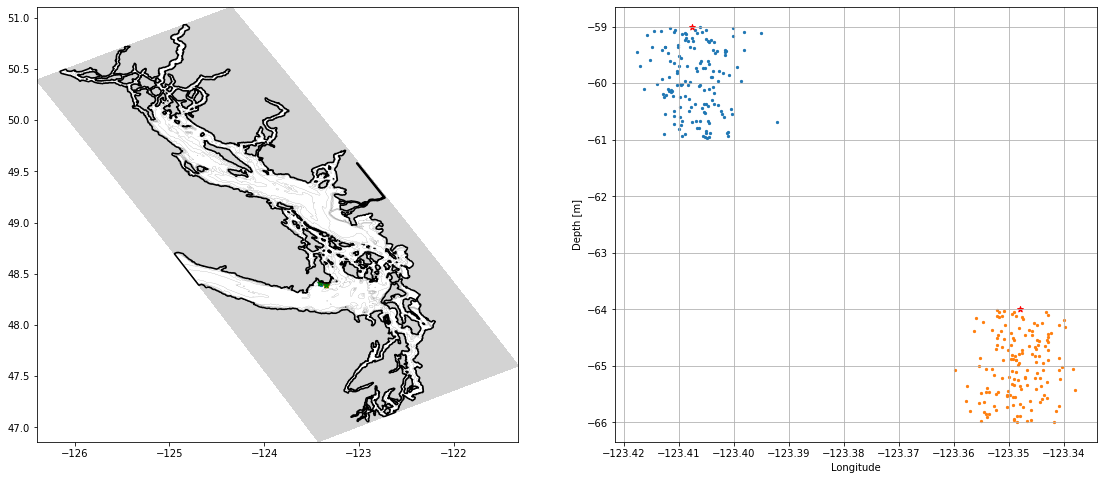

In [18]:
visual2(outfile,N,n,clon,clat,dmin,dd,0,0,local)

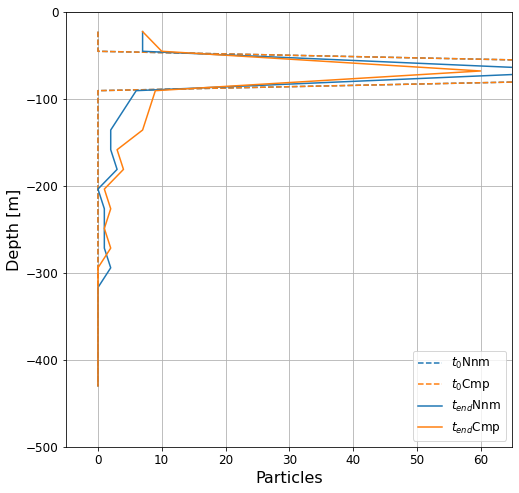

In [19]:
profile(N,n,length,outfile,local)

In [20]:
#anim=mapanimation(outfile,N,n,clon,clat,1,0)
#anim

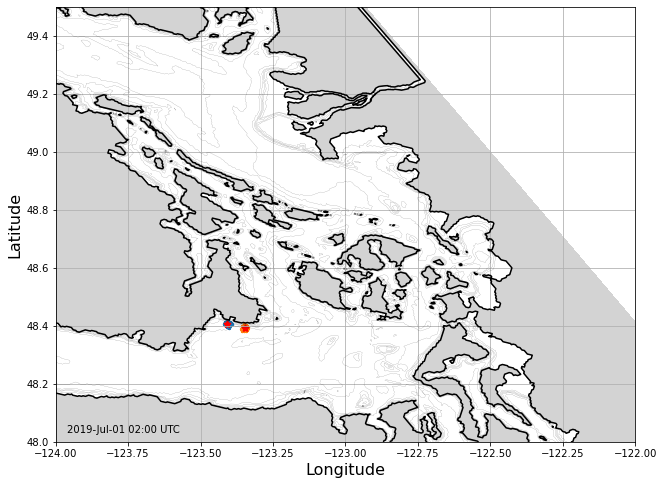

In [21]:
fps=2
anim = mapanimation_vic(outfile,N,n,clon,clat,fps,local)
f = r"/home/jvalenti/MOAD/animations/VictoriaSummer2.mp4" 
FFwriter = animation.FFMpegWriter()
anim.save(f, writer = FFwriter)

In [22]:
with open(f,'rb') as anim:
    display(Image(anim.read()))